<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


<h1>Linear Regression 1D: Training Two Parameter Mini-Batch Gradient Decent</h1>


<h2>Objective</h2><ul><li> How to use Mini-Batch Gradient Descent to train model.</li></ul> 


<h2>Table of Contents</h2>
<p>In this Lab, you will practice training a model by using Mini-Batch Gradient Descent.</p>

<ul>
    <li><a href="#Makeup_Data">Make Some Data</a></li>
    <li><a href="#Model_Cost">Create the Model and Cost Function (Total Loss)</a></li>
    <li><a href="#BGD">Train the Model: Batch Gradient Descent</a></li>
    <li><a href="#SGD">Train the Model: Stochastic Gradient Descent with Dataset DataLoader</a></li>
    <li><a href="#Mini5">Train the Model: Mini Batch Gradient Decent: Batch Size Equals 5</a></li>
    <li><a href="#Mini10">Train the Model: Mini Batch Gradient Decent: Batch Size Equals 10</a></li>
</ul>
<p>Estimated Time Needed: <strong>30 min</strong></p>
</div>

<hr>


<h2>Preparation</h2>


We'll need the following libraries:


In [1]:
# Import the libraries we need for this lab

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

The class <code>plot_error_surfaces</code> is just to help you visualize the data space and the parameter space during training and has nothing to do with PyTorch. 


In [2]:
# The class for plotting the diagrams

class plot_error_surfaces(object):

    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go is True:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()

    # Setter
    def set_para_loss(self, W, B, loss):
        self.n = self.n + 1
        self.W.append(W)
        self.B.append(B)
        self.LOSS.append(loss)

    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c='r', marker='x', s=200, alpha=1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim()
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label="estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title('Loss Surface Contour')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Make Some Data </h2>


Import PyTorch and set random seed:


In [3]:
# Import PyTorch library

import torch
torch.manual_seed(1)

Generate values from -3 to 3 that create a line with a slope of 1 and a bias of -1. This is the line that you need to estimate. Add some noise to the data:


In [4]:
# Generate the data with noise and the line

X = torch.arange(-3, 3, 0.1).view(-1, 1)
f = 1 * X - 1
Y = f + 0.1 * torch.randn(X.size())

Plot the results:


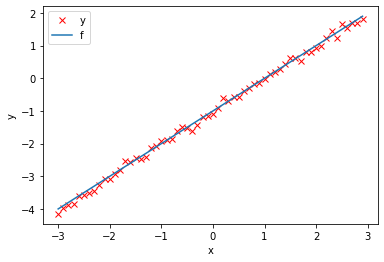

In [5]:
# Plot the line and the data

plt.plot(X.numpy(), Y.numpy(), 'rx', label = 'y')
plt.plot(X.numpy(), f.numpy(), label = 'f')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<!--Empty Space for separating topics-->


<h2 id="Model_Cost">Create the Model and Cost Function (Total Loss) </h2>


Define the <code>forward</code> function: 


In [6]:
# Define the prediction function

def forward(x):
    return w * x + b

Define the cost or criterion function: 


In [7]:
# Define the cost function

def criterion(yhat, y):
    return torch.mean((yhat - y) ** 2)

Create a <code> plot_error_surfaces</code> object to visualize the data space and the parameter space during training:


<Figure size 432x288 with 0 Axes>

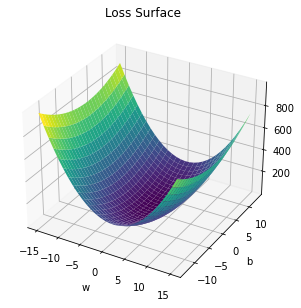

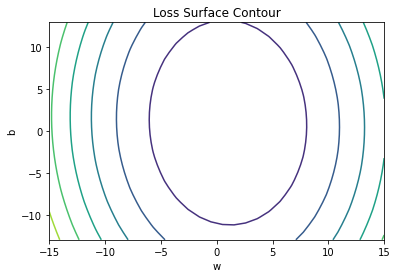

In [8]:
# Create a plot_error_surfaces object.

get_surface = plot_error_surfaces(15, 13, X, Y, 30)

<!--Empty Space for separating topics-->


<h2>Train the Model: Batch Gradient Descent (BGD)</h2>


Define <code>train_model_BGD</code> function.


In [9]:
# Define the function for training model

w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)
lr = 0.1
LOSS_BGD = []


def train_model_BGD(epochs):
    for epoch in range(epochs):
        Yhat = forward(X)
        loss = criterion(Yhat, Y)
        LOSS_BGD.append(loss)
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
        get_surface.plot_ps()
        loss.backward()
        w.data = w.data - lr * w.grad.data
        b.data = b.data - lr * b.grad.data
        w.grad.data.zero_()
        b.grad.data.zero_()

Run 10 epochs of batch gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space. 


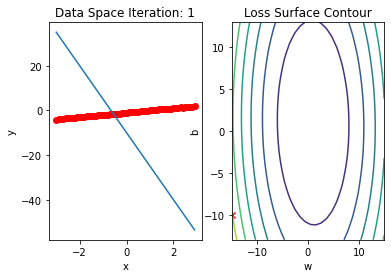

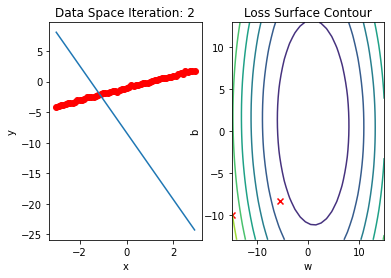

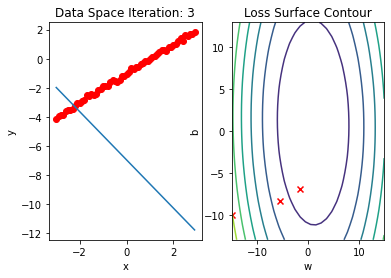

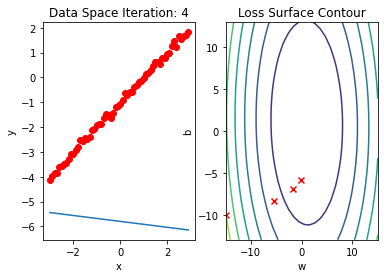

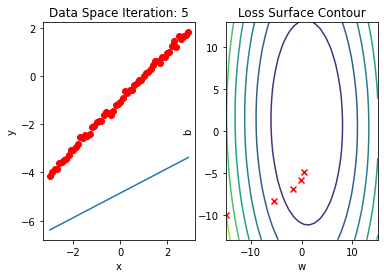

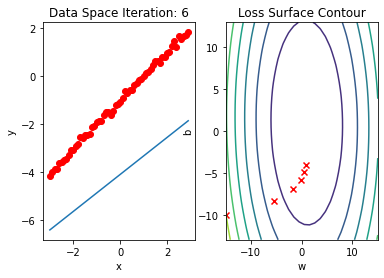

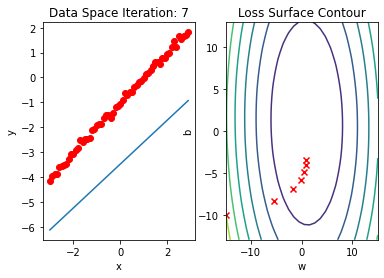

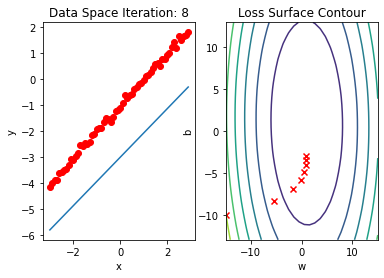

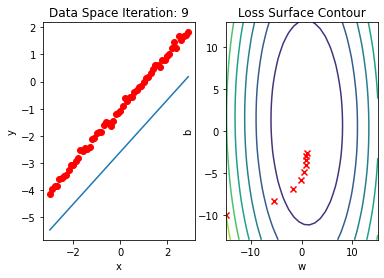

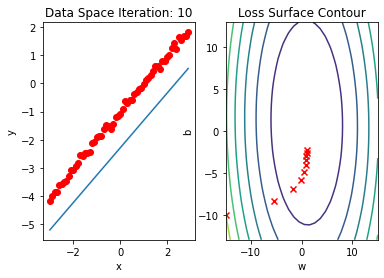

In [10]:
# Run train_model_BGD with 10 iterations

train_model_BGD(10)

<!--Empty Space for separating topics-->


<h2 id="SGD"> Stochastic Gradient Descent (SGD) with Dataset DataLoader</h2>


Create a <code>plot_error_surfaces</code> object to visualize the data space and the parameter space during training:


In [11]:
# Create a plot_error_surfaces object.

get_surface = plot_error_surfaces(15, 13, X, Y, 30, go = False)

Import <code>Dataset</code> and <code>DataLoader</code> libraries


In [12]:
# Import libraries

from torch.utils.data import Dataset, DataLoader

Create <code>Data</code> class


In [14]:
# Create class Data

class Data(Dataset):

    # Constructor
    def __init__(self):
        self.x = torch.arange(-3, 3, 0.1).view(-1, 1)
        self.y = 1 * X - 1
        self.len = self.x.shape[0]

    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]

    # Get length
    def __len__(self):
        return self.len

Create a dataset object and a dataloader object: 


In [15]:
# Create Data object and DataLoader object

dataset = Data()
trainloader = DataLoader(dataset = dataset, batch_size = 1)

Define <code>train_model_SGD</code> function for training the model.


In [16]:
# Define train_model_SGD function

w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)
LOSS_SGD = []
lr = 0.1


def train_model_SGD(epochs):
    for epoch in range(epochs):
        Yhat = forward(X)
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), \
                                  criterion(Yhat, Y).tolist())
        get_surface.plot_ps()
        LOSS_SGD.append(criterion(forward(X), Y).tolist())
        for x, y in trainloader:
            yhat = forward(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
            loss.backward()
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()
        get_surface.plot_ps()

Run 10 epochs of stochastic gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space. 


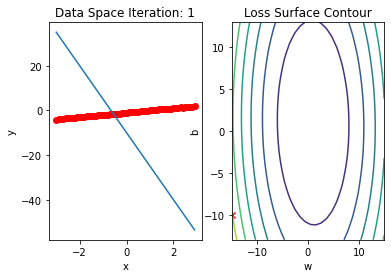

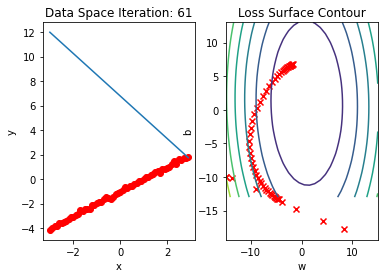

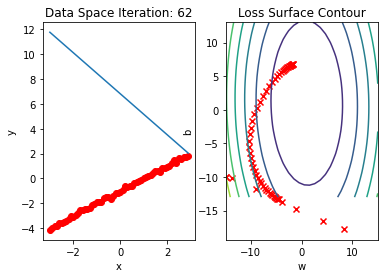

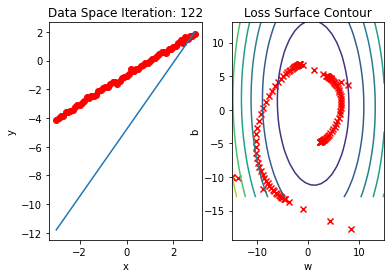

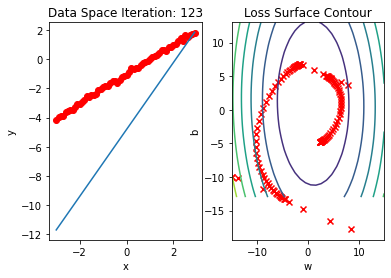

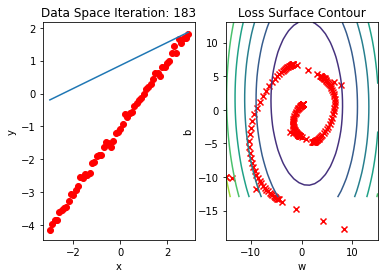

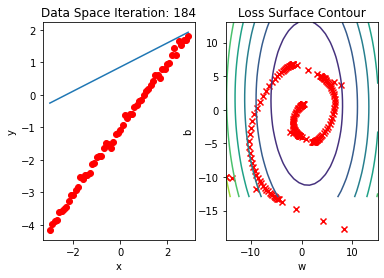

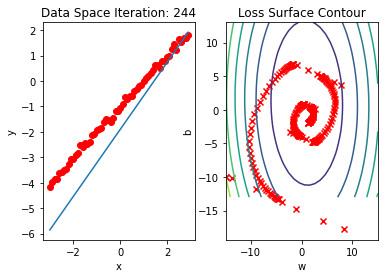

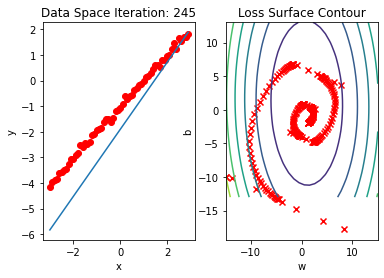

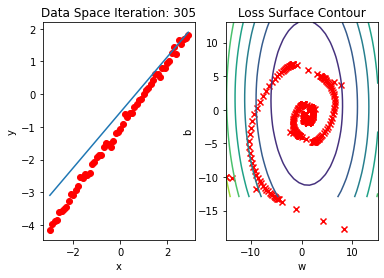

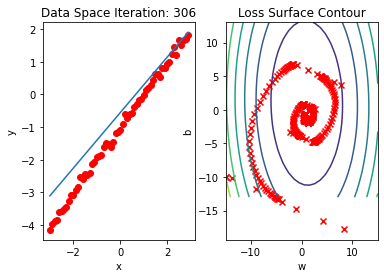

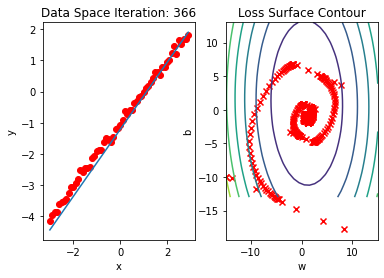

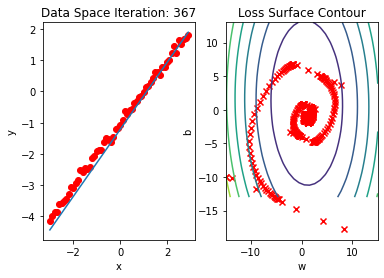

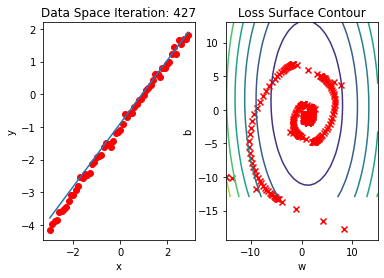

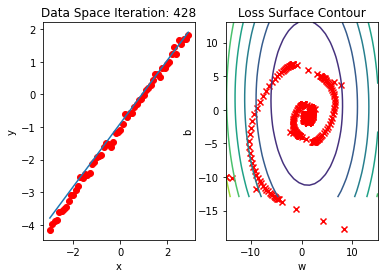

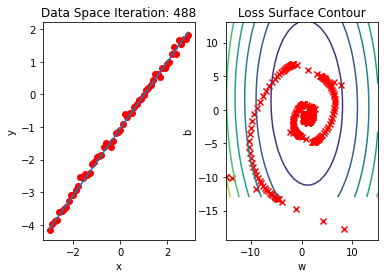

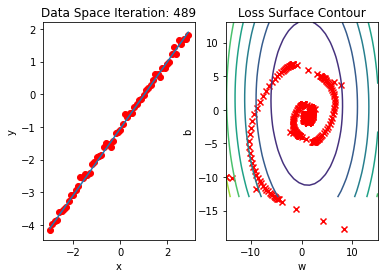

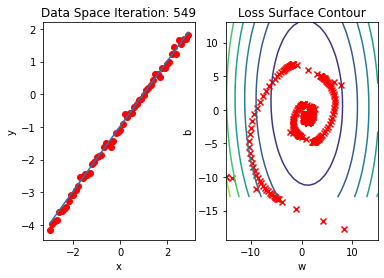

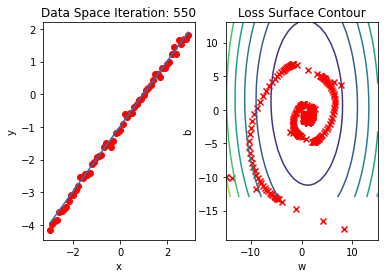

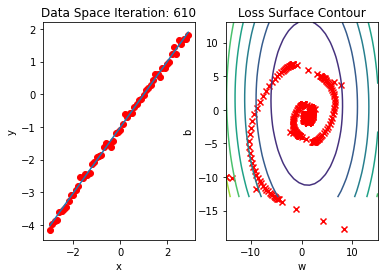

In [17]:
# Run train_model_SGD(iter) with 10 iterations

train_model_SGD(10)

<!--Empty Space for separating topics-->


<h2 id="Mini5">Mini Batch Gradient Descent: Batch Size Equals 5</h2> 


Create a <code> plot_error_surfaces</code> object to visualize the data space and the parameter space during training:


In [18]:
# Create a plot_error_surfaces object.

get_surface = plot_error_surfaces(15, 13, X, Y, 30, go=False)

Create <code>Data</code> object and create a <code>Dataloader</code> object where the batch size equals 5:


In [19]:
# Create DataLoader object and Data object

dataset = Data()
trainloader = DataLoader(dataset=dataset, batch_size=5)

Define <code>train_model_Mini5</code> function to train the model.


In [20]:
# Define train_model_Mini5 function

w = torch.tensor(-15.0, requires_grad=True)
b = torch.tensor(-10.0, requires_grad=True)
LOSS_MINI5 = []
lr = 0.1


def train_model_Mini5(epochs):
    for epoch in range(epochs):
        Yhat = forward(X)
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), \
                                  criterion(Yhat, Y).tolist())
        get_surface.plot_ps()
        LOSS_MINI5.append(criterion(forward(X), Y).tolist())
        for x, y in trainloader:
            yhat = forward(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), \
                                      loss.tolist())
            loss.backward()
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()

Run 10 epochs of mini-batch gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space. 


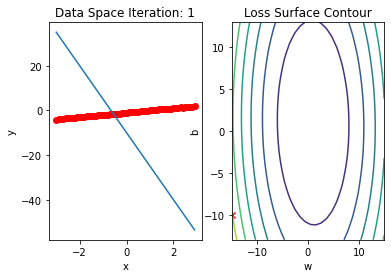

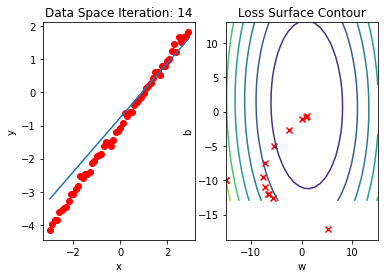

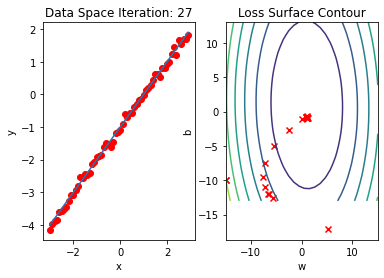

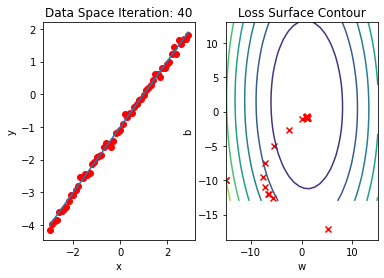

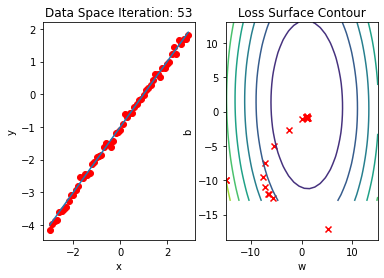

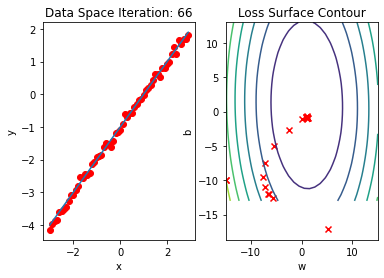

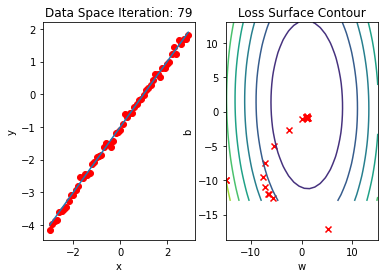

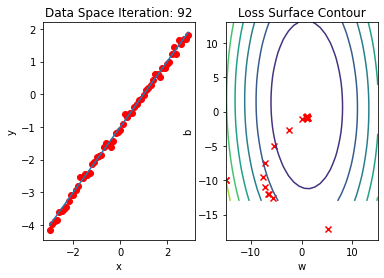

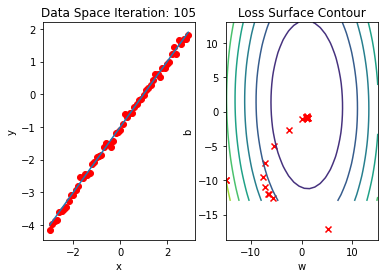

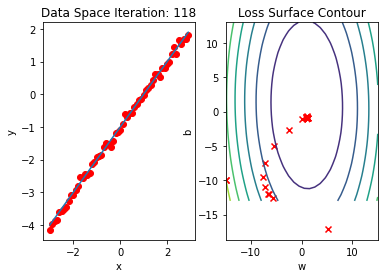

In [21]:
# Run train_model_Mini5 with 10 iterations.

train_model_Mini5(10)

<!--Empty Space for separating topics-->


<h2 id="Mini10">Mini Batch Gradient Descent: Batch Size Equals 10</h2> 


Create a <code> plot_error_surfaces</code> object to visualize the data space and the parameter space during training:


In [22]:
# Create a plot_error_surfaces object.

get_surface = plot_error_surfaces(15, 13, X, Y, 30, go=False)

Create <code>Data</code> object and create a <code>Dataloader</code> object batch size equals 10


In [23]:
# Create DataLoader object

dataset = Data()
trainloader = DataLoader(dataset=dataset, batch_size=10)

Define <code>train_model_Mini10</code> function for training the model.


In [24]:
# Define train_model_Mini5 function

w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)
LOSS_MINI10 = []
lr = 0.1


def train_model_Mini10(epochs):
    for epoch in range(epochs):
        Yhat = forward(X)
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), \
                                  criterion(Yhat, Y).tolist())
        get_surface.plot_ps()
        LOSS_MINI10.append(criterion(forward(X), Y).tolist())
        for x, y in trainloader:
            yhat = forward(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), \
                                      loss.tolist())
            loss.backward()
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()

Run 10 epochs of mini-batch gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space. 


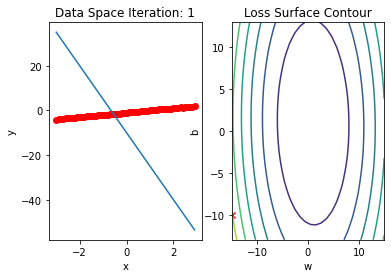

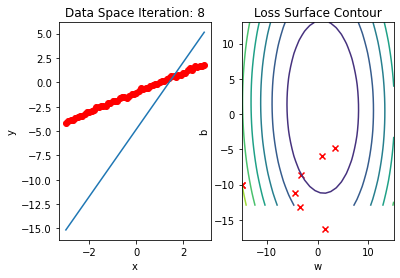

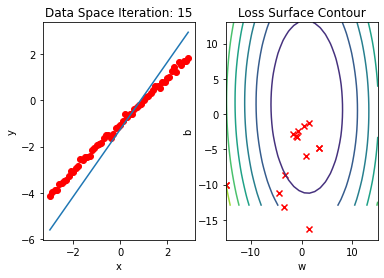

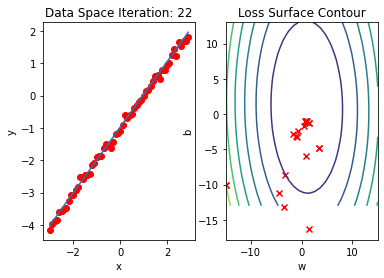

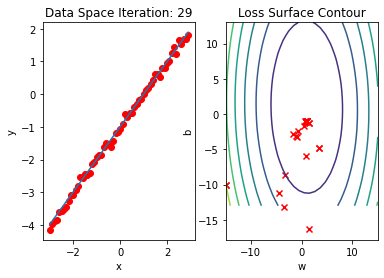

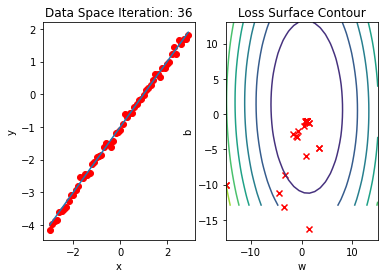

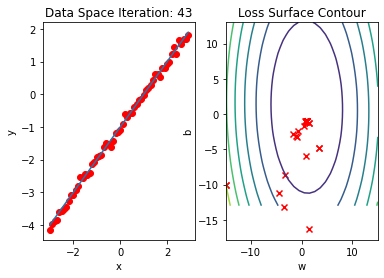

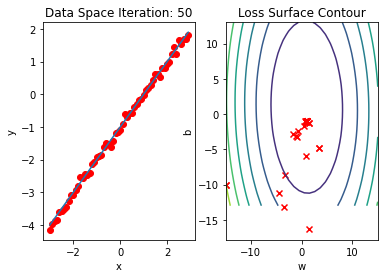

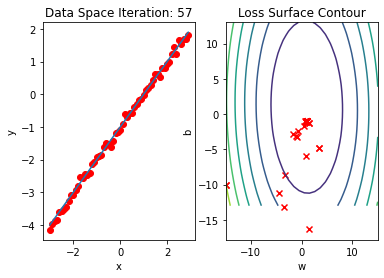

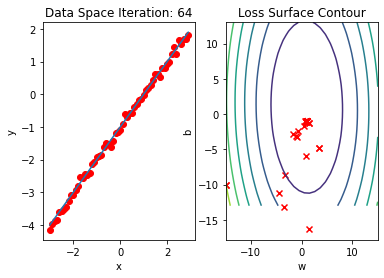

In [25]:
# Run train_model_Mini5 with 10 iterations.

train_model_Mini10(10)

Plot the loss for each epoch:  


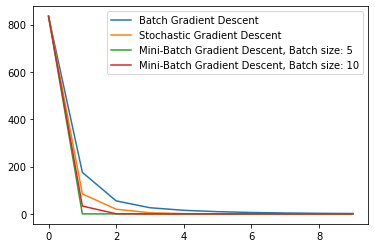

In [26]:
# Plot out the LOSS for each method

plt.plot(LOSS_BGD,label = "Batch Gradient Descent")
plt.plot(LOSS_SGD,label = "Stochastic Gradient Descent")
plt.plot(LOSS_MINI5,label = "Mini-Batch Gradient Descent, Batch size: 5")
plt.plot(LOSS_MINI10,label = "Mini-Batch Gradient Descent, Batch size: 10")
plt.legend()

<!--Empty Space for separating topics-->


<h3>Practice</h3>


Perform mini batch gradient descent with a batch size of 20. Store the total loss for each epoch in the list LOSS20.  


In [30]:
# Practice: Perform mini batch gradient descent with a batch size of 20.

dataset = Data()

w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)
LOSS_MINI20 = []
lr = 0.1


def train_model_Mini20(epochs):
    for epoch in range(epochs):
        Yhat = forward(X)
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), \
                                  criterion(Yhat, Y).tolist())
        get_surface.plot_ps()
        LOSS_MINI20.append(criterion(forward(X), Y).tolist())
        for x, y in trainloader:
            yhat = forward(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), \
                                      loss.tolist())
            loss.backward()
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()

Double-click <b>here</b> for the solution.

<!-- 
trainloader = DataLoader(dataset = dataset, batch_size = 20)
w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)

LOSS_MINI20 = []
lr = 0.1

def my_train_model(epochs):
    for epoch in range(epochs):
        Yhat = forward(X)
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), criterion(Yhat, Y).tolist())
        get_surface.plot_ps()
        LOSS_MINI20.append(criterion(forward(X), Y).tolist())
        for x, y in trainloader:
            yhat = forward(x)
            loss = criterion(yhat, y)
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
            loss.backward()
            w.data = w.data - lr * w.grad.data
            b.data = b.data - lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()

my_train_model(10)
-->


Plot a graph that shows the LOSS results for all the methods.


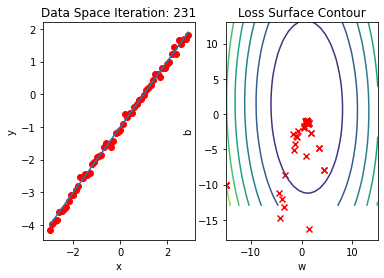

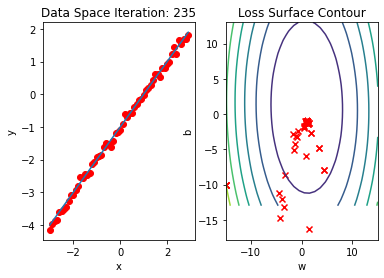

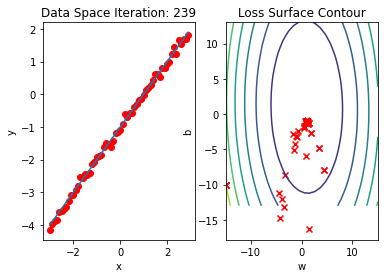

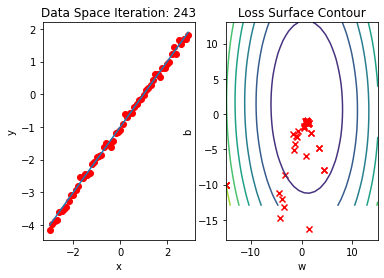

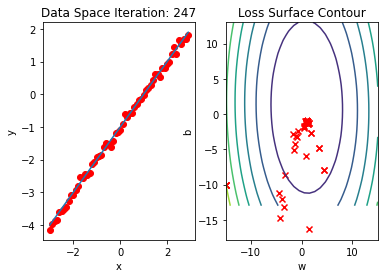

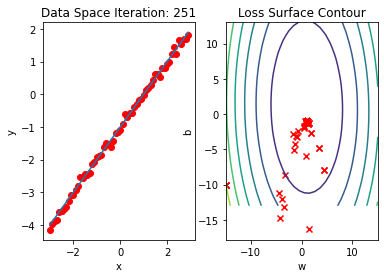

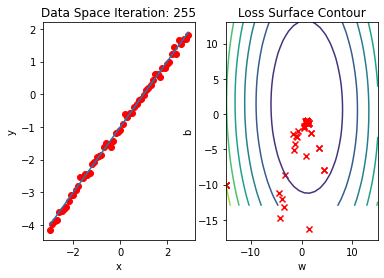

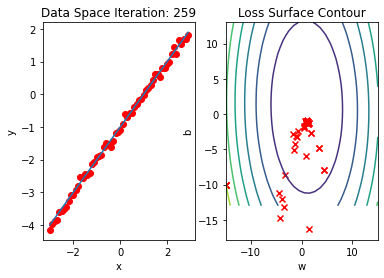

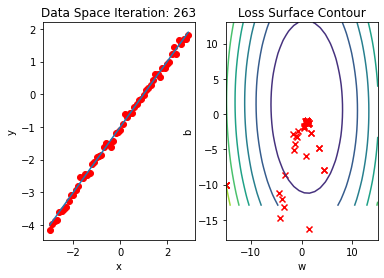

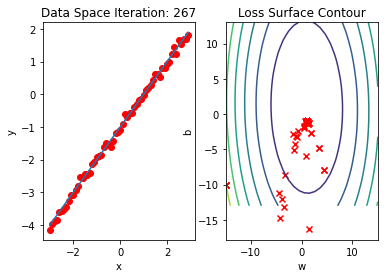

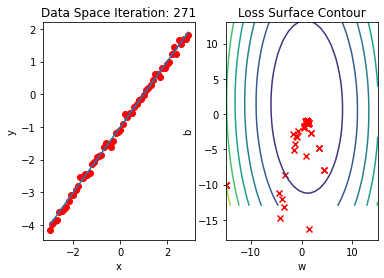

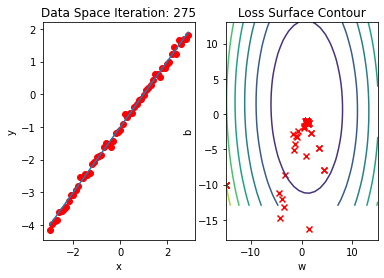

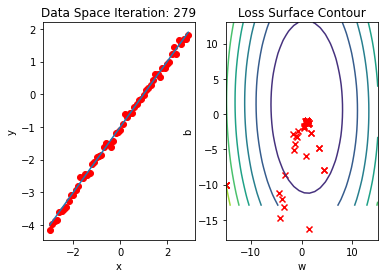

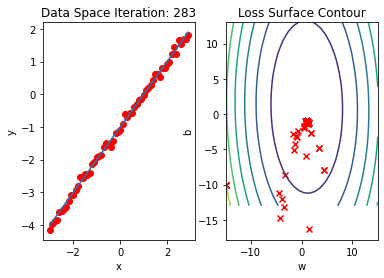

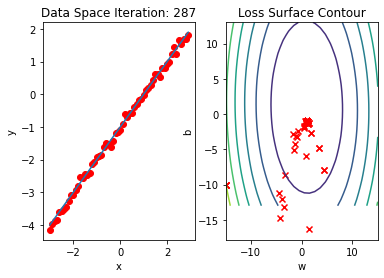

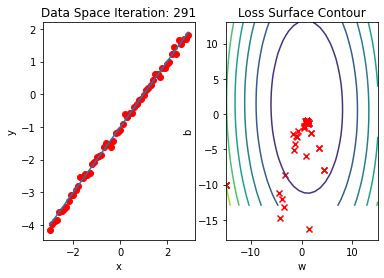

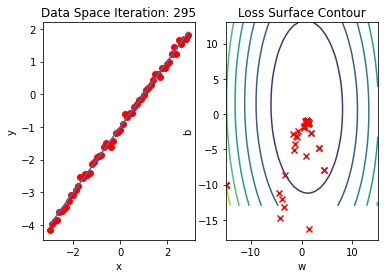

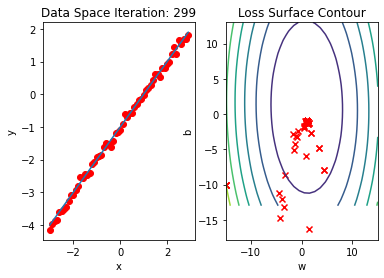

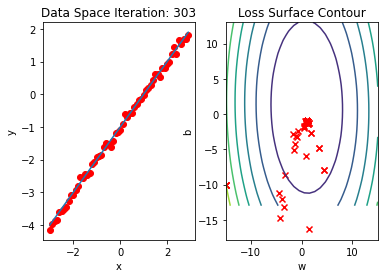

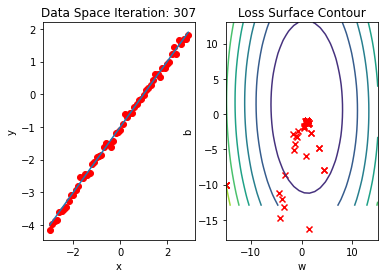

In [32]:
# Practice: Plot a graph to show all the LOSS functions

# Type your code here
train_model_Mini20(20)

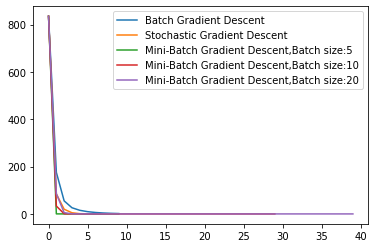

In [33]:
plt.plot(LOSS_BGD, label = "Batch Gradient Descent")
plt.plot(LOSS_SGD, label = "Stochastic Gradient Descent")
plt.plot(LOSS_MINI5, label = "Mini-Batch Gradient Descent,Batch size:5")
plt.plot(LOSS_MINI10, label = "Mini-Batch Gradient Descent,Batch size:10")
plt.plot(LOSS_MINI20, label = "Mini-Batch Gradient Descent,Batch size:20")
plt.legend()

Double-click <b>here</b> for the solution.

<!-- 
plt.plot(LOSS_BGD, label = "Batch Gradient Descent")
plt.plot(LOSS_SGD, label = "Stochastic Gradient Descent")
plt.plot(LOSS_MINI5, label = "Mini-Batch Gradient Descent,Batch size:5")
plt.plot(LOSS_MINI10, label = "Mini-Batch Gradient Descent,Batch size:10")
plt.plot(LOSS_MINI20, label = "Mini-Batch Gradient Descent,Batch size:20")
plt.legend()
-->


<a href="https://dataplatform.cloud.ibm.com/registration/stepone?context=cpdaas&apps=data_science_experience,watson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"/></a>


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                                          |
| ----------------- | ------- | ---------- | ----------------------------------------------------------- |
| 2020-09-23        | 2.0     | Shubham    | Migrated Lab to Markdown and added to course repo in GitLab |


<hr>


## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
